In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Load the data
df = pd.read_csv('final_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'], format='%d-%m-%Y %H:%M')
df.set_index('datetime', inplace=True)

# Feature engineering
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Create lag features
for target in ['DELHI', 'BRPL', 'BYPL', 'NDMC', 'MES']:
    df[f'{target}_lag_1'] = df[target].shift(1)
    df[f'{target}_lag_24'] = df[target].shift(24)

# Drop rows with NaN values after creating lag features
df.dropna(inplace=True)

# Prepare features and target variables
categorical_features = ['weekday', 'hour', 'day_of_week', 'month', 'is_weekend']
numerical_features = ['temperature', 'humidity', 'wind_speed', 'precipitation'] + [f'{target}_lag_1' for target in ['DELHI', 'BRPL', 'BYPL', 'NDMC', 'MES']] + [f'{target}_lag_24' for target in ['DELHI', 'BRPL', 'BYPL', 'NDMC', 'MES']]
features = numerical_features + categorical_features
targets = ['DELHI', 'BRPL', 'BYPL', 'NDMC', 'MES']

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit and transform the features
X = preprocessor.fit_transform(df)

# Normalize the target variables separately
y = np.zeros_like(df[targets].values)
scalers_y = {}
for i, target in enumerate(targets):
    scaler = StandardScaler()
    y[:, i] = scaler.fit_transform(df[[target]]).ravel()
    scalers_y[target] = scaler

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input data for GRU (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the improved GRU model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    GRU(64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    GRU(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(targets))
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Implement early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, 
                    verbose=1, callbacks=[early_stopping, lr_reducer])

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_test_inv = np.zeros_like(y_test)
y_pred_inv = np.zeros_like(y_pred)
for i, target in enumerate(targets):
    y_test_inv[:, i] = scalers_y[target].inverse_transform(y_test[:, i].reshape(-1, 1)).ravel()
    y_pred_inv[:, i] = scalers_y[target].inverse_transform(y_pred[:, i].reshape(-1, 1)).ravel()

# Calculate and display metrics for each target
for i, target in enumerate(targets):
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i]))
    mape = mean_absolute_percentage_error(y_test_inv[:, i], y_pred_inv[:, i]) * 100
    r2 = r2_score(y_test_inv[:, i], y_pred_inv[:, i])
    
    print(f"{target}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R2: {r2:.2f}")
    print()

Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 2.3188 - val_loss: 1.0365 - learning_rate: 0.0010
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9019 - val_loss: 0.7728 - learning_rate: 0.0010
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6466 - val_loss: 0.5374 - learning_rate: 0.0010
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.5181 - val_loss: 0.3641 - learning_rate: 0.0010
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4464 - val_loss: 0.2820 - learning_rate: 0.0010
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3888 - val_loss: 0.2377 - learning_rate: 0.0010
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3500 - val_loss: 0.2205 - learning_rate: 0.0010
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.3191 - val_loss: 0.2071 - learning_rate: 0.0010
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.3017 - val_loss: 0.1949 - learning_rate

MES data summary:
count    11405.000000
mean        28.533460
std          8.760497
min          0.000000
25%         22.020000
50%         28.080000
75%         34.300000
max         61.440000
Name: MES, dtype: float64


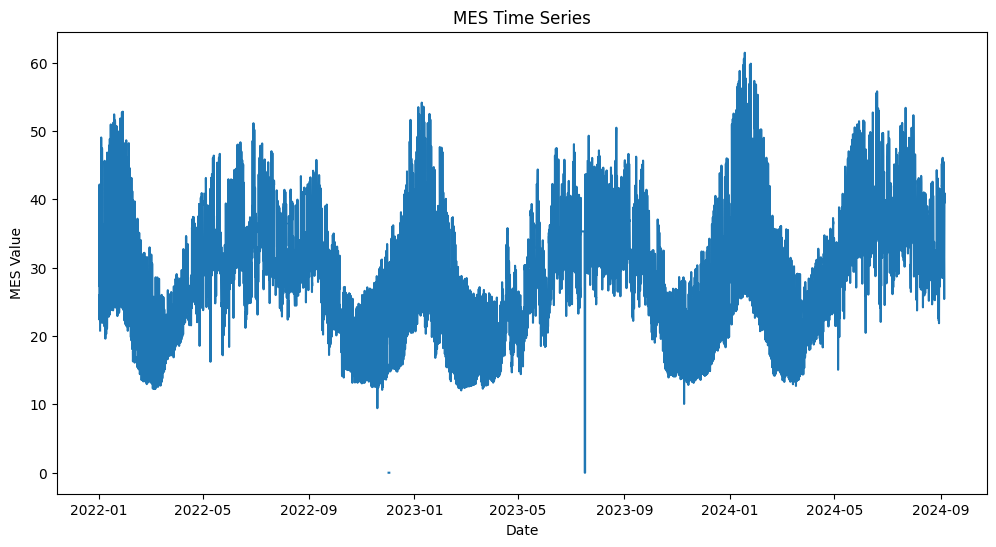

DELHI:
  RMSE: 159.64
  Adjusted MAPE: 3.10%
  R2: 0.99
  Min actual value: 1318.11
  Max actual value: 8302.79
  Min predicted value: 1659.95
  Max predicted value: 7936.17

BRPL:
  RMSE: 80.41
  Adjusted MAPE: 3.66%
  R2: 0.98
  Min actual value: 480.36
  Max actual value: 3603.25
  Min predicted value: 651.45
  Max predicted value: 3451.03

BYPL:
  RMSE: 42.57
  Adjusted MAPE: 4.26%
  R2: 0.98
  Min actual value: 244.22
  Max actual value: 1806.94
  Min predicted value: 297.78
  Max predicted value: 1733.97

NDMC:
  RMSE: 11.09
  Adjusted MAPE: 4.97%
  R2: 0.97
  Min actual value: 24.21
  Max actual value: 420.89
  Min predicted value: 72.47
  Max predicted value: 409.63

MES:
  RMSE: 1.90
  Adjusted MAPE: 2161.54%
  R2: 0.95
  Min actual value: 0.00
  Max actual value: 59.84
  Min predicted value: 13.48
  Max predicted value: 55.12



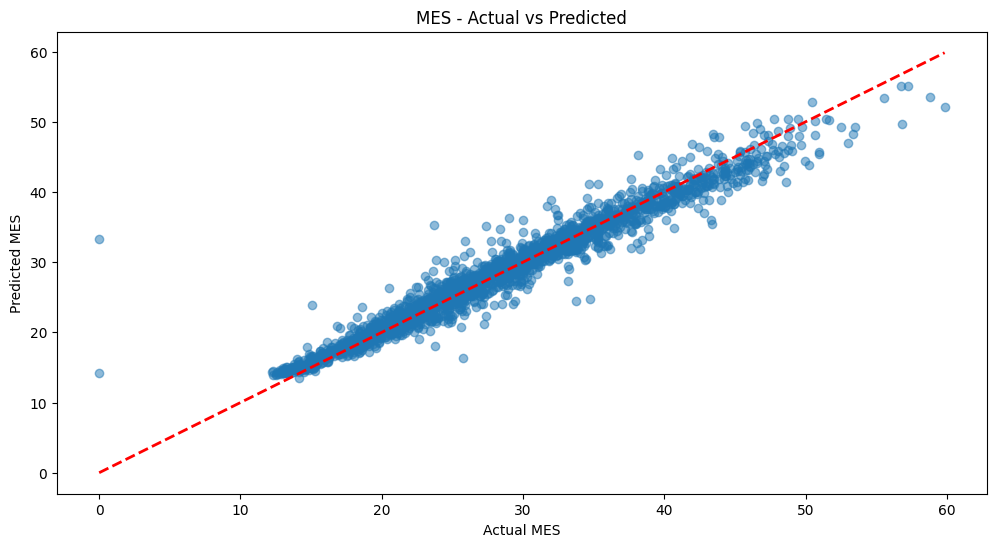

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
df = pd.read_csv('final_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'], format='%d-%m-%Y %H:%M')
df.set_index('datetime', inplace=True)

# Analyze MES data
print("MES data summary:")
print(df['MES'].describe())

plt.figure(figsize=(12, 6))
plt.plot(df['MES'])
plt.title('MES Time Series')
plt.xlabel('Date')
plt.ylabel('MES Value')
plt.show()

# Function to calculate adjusted MAPE
def adjusted_mape(y_true, y_pred, epsilon=1e-3):
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Assuming y_test_inv and y_pred_inv are already calculated
for i, target in enumerate(targets):
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i]))
    adjusted_mape_value = adjusted_mape(y_test_inv[:, i], y_pred_inv[:, i])
    r2 = r2_score(y_test_inv[:, i], y_pred_inv[:, i])
    
    print(f"{target}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  Adjusted MAPE: {adjusted_mape_value:.2f}%")
    print(f"  R2: {r2:.2f}")
    print(f"  Min actual value: {y_test_inv[:, i].min():.2f}")
    print(f"  Max actual value: {y_test_inv[:, i].max():.2f}")
    print(f"  Min predicted value: {y_pred_inv[:, i].min():.2f}")
    print(f"  Max predicted value: {y_pred_inv[:, i].max():.2f}")
    print()

# Plot actual vs predicted for MES
plt.figure(figsize=(12, 6))
plt.scatter(y_test_inv[:, targets.index('MES')], y_pred_inv[:, targets.index('MES')], alpha=0.5)
plt.plot([y_test_inv[:, targets.index('MES')].min(), y_test_inv[:, targets.index('MES')].max()], 
         [y_test_inv[:, targets.index('MES')].min(), y_test_inv[:, targets.index('MES')].max()], 
         'r--', lw=2)
plt.xlabel('Actual MES')
plt.ylabel('Predicted MES')
plt.title('MES - Actual vs Predicted')
plt.show()

In [ ]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100